# Identifying feedback ISGs

In [4]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline

In [5]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [7]:
data_path = '/data_volume/memento/hbec/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [8]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [9]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.shape

(69958, 36588)

### Find IFN genes

In [36]:
ifn_genes = []
for g in adata.var.index:
    if ('IFNA' in g or 'IFNB' in g) and 'R' not in g:
        ifn_genes.append(g)

In [37]:
combined_ifn = adata[:, ifn_genes].X.sum(axis=1).A1

In [39]:
combined_ifn.sum()

5.0

(array([5.6755e+04, 8.6380e+03, 2.9820e+03, 1.0600e+03, 3.4100e+02,
        1.0800e+02, 5.1000e+01, 1.8000e+01, 3.0000e+00, 2.0000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

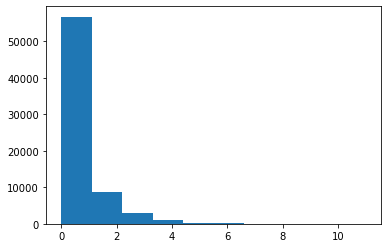

In [34]:
plt.hist(combined_ifn)

### Setup memento

In [11]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [12]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [13]:
memento.setup_memento(adata, q_column='q')

In [14]:
adata.obs.head(3)

,NUM.SNPS,BEST.GUESS,DROPLET.TYPE,batch,HTO_classification,condition,donor,stim,time,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden,cell_type,q,memento_size_factor
AAACCCAAGGAAGTAG-1,1700,donor0,SNG,0,hash-10,d2513_lambda_9,d2513,lambda,9,4297,4297,12191.0,1394.0,11.434665,3,ciliated,0.10425,0.955289
AAACCCAAGGGACTGT-1,839,donor0,SNG,0,hash-3,d2513_alpha_24,d2513,alpha,24,2171,2171,7270.0,386.0,5.309491,5,bc,0.10425,0.824407
AAACCCACAATCTGCA-1,1130,donor1,SNG,0,hash-1,d2614_alpha_3,d2614,alpha,3,3016,3016,9544.0,516.0,5.406538,0,basal,0.10425,0.988939


### Run memento for each subset, comparing to control

In [18]:
ct = 'ciliated'
tp = '3'
stim = 'beta'

In [22]:
adata_stim = adata.copy()[
    (adata.obs.cell_type==ct) & \
    adata.obs.stim.isin(['control', stim]) & \
    adata.obs.time.isin(['0',tp]), :].copy()
time_converter={0:0, int(tp):1}
adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)

In [ ]:


memento.ht_1d_moments(
    adata_stim, 
    formula_like='1 + time_step',
    cov_column='time_step', 
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

In [18]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/binary_test_deep/')

In [20]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_20200313.h5ad'.format('-'.join(ct), stim, tp)
            
            if fname in done_files:
                print('Skipping', fname)
                continue

            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)

            memento.ht_1d_moments(
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            del adata_stim.uns['memento']['mv_regressor']

            adata_stim.write('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200313.h5ad'.format(
                '-'.join(ct), stim, tp))

starting ['ciliated'] 3 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    7.2s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   14.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   24.5s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.6s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   51.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 3 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.1s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.0s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 3 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   33.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 3 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.1s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 6 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   20.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   31.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   45.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.1min
[Parallel(n_jo

starting ['ciliated'] 6 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.8s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.2s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   51.6s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 6 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.6s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   32.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 6 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   32.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.3s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 9 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   20.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   31.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   45.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.1min
[Parallel(n_jo

starting ['ciliated'] 9 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.3s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   33.2s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.6s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 9 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.7s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.7s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   33.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   48.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 9 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 24 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 322 tasks      | elapsed:    8.3s
[Parallel(n_jobs=13)]: Done 822 tasks      | elapsed:   21.1s
[Parallel(n_jobs=13)]: Done 1522 tasks      | elapsed:   38.3s
[Parallel(n_jobs=13)]: Done 2422 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 3522 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4822 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 6322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=13)]: Done 8022 tasks      | elapsed:  3.3min
[Parallel(n_jobs=13)]: Done 9093 out of 9093 | elapsed:  3.8min finished
...

starting ['ciliated'] 24 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.9s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.2s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.4s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 24 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.6s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   23.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   36.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   52.3s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  2.0min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 24 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.5s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   35.3s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   50.8s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.5min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.4min
[Parallel(n_jo

starting ['ciliated'] 48 alpha


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.4s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.0s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   32.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   47.1s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.2min
[Parallel(n_jo

starting ['ciliated'] 48 beta


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.5s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   11.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   20.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   31.8s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   45.5s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.0min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.1min
[Parallel(n_jo

starting ['ciliated'] 48 gamma


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.4s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   22.4s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   34.7s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   49.4s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo

starting ['ciliated'] 48 lambda


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    0.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    4.8s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   12.0s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   21.8s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   33.9s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   48.7s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.1min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  1.4min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  1.8min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  2.3min
[Parallel(n_jo